# Assignment 1

DATASET (MNIST): http://yann.lecun.com/exdb/mnist/

Train 1 denoising and 1 contractive autoencoder on the MNIST dataset. It is up to you to decide how many layers and neurons in each layer and how many layers you want in the deep autoencoder. Show an accuracy comparison between the different autoencoders.

Then, experiment with what happens if you feed the autoencoders with a random noise image and then you apply the iterative gradient ascent process described in the lecture to see if the reconstruction converges to the data manifold. Confront the reconstructions created by the 2 different models and comment on the results.

In [1]:
import torch
import itertools as it

from torch import nn

class AutoEncoder(nn.Module):
    def __init__(self,encoder_sizes,decoder_sizes):
        super(AutoEncoder, self).__init__()
        encoder_layers=[]
        for sx,dx in it.pairwise(encoder_sizes):
            encoder_layers.append(nn.Linear(sx,dx))
            encoder_layers.append(nn.ReLU())
        decoder_layers=[]
        for sx,dx in it.pairwise(decoder_sizes[:-1]):
            decoder_layers.append(nn.Linear(sx,dx))
            decoder_layers.append(nn.ReLU())
        decoder_layers.append(nn.Linear(decoder_sizes[-2],decoder_sizes[-1]))
        decoder_layers.append(nn.Sigmoid())

        self.encoder = nn.Sequential(
            *encoder_layers
        )
        self.decoder = nn.Sequential(
            *decoder_layers
        )

    def forward(self, x):
        encoded = self.encoder(x)
        encoded.retain_grad()
        decoded = self.decoder(encoded)
        return encoded, decoded

In [2]:

import torchvision
import torchvision.transforms as transforms
dataset=torchvision.datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
dataset.requires_grad=True
dataloader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=False)


DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
import matplotlib.pyplot as plt 




def train_denoising_ae(ae,data,n_epochs=10):
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(ae.parameters(), lr=0.001)
    for epoch in range(n_epochs):
        for sample in data:
            img, _ = sample
            img_noisy = img + torch.randn(img.size())
            img_noisy = img_noisy.view(-1, 28*28)
            img = img.view(-1, 28*28)
            optimizer.zero_grad()

            img=img.to(DEVICE)
            img_noisy=img_noisy.to(DEVICE)
            _, output = ae(img_noisy)
            loss = criterion(output, img)
            loss.backward()
            optimizer.step()
            MSE_loss = nn.MSELoss()(output, img)
        print(f'epoch [{epoch + 1}/{n_epochs}], loss:{MSE_loss.item():.4f}')
dae=AutoEncoder([28*28, 256, 64], [64,256, 28*28]).to(DEVICE)
train_denoising_ae(dae,dataloader,20)

epoch [1/20], loss:0.0432


KeyboardInterrupt: 

In [31]:
def jacobian_penalty_term(encoder, inputs):
    """ jacobian = torch.autograd.grad(outputs=hidden, inputs=inputs,
                                   grad_outputs=torch.ones_like(hidden),
                                   create_graph=True, retain_graph=True, only_inputs=True)[0]
    jacobian = jacobian.view(jacobian.size(0), -1)
    penalty_term = torch.norm(jacobian, p=2, dim=1)**2 """
    jacobian=torch.autograd.functional.jacobian(encoder.encoder, inputs)
    penalty_term = torch.sum(jacobian**2)
    return penalty_term

def train_contractive_ae(ae,data,n_epochs=10,contractive_penalty=1e-4):
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(ae.parameters(), lr=0.001)
    for epoch in range(n_epochs):
        for i,sample in enumerate(data):
            batch, _ = sample
            batch = batch.view(-1, 28*28).to(DEVICE)
            for img in batch:
                img.requires_grad = True
                img.retain_grad()
                optimizer.zero_grad()
                hidden, output = ae(img)
                loss = criterion(output, img) + contractive_penalty * jacobian_penalty_term(ae, img)
                loss.backward()
                optimizer.step()
        print(f'epoch [{epoch + 1}/{n_epochs}], loss:{loss.item():.4f}')
#needed in order to compute the jacobian

cae=AutoEncoder([28*28, 256, 64], [64, 256, 28*28]).to(DEVICE)
train_contractive_ae(cae,dataloader,20)

epoch [1/20], loss:0.1601


KeyboardInterrupt: 

In [11]:
def generate_data_point(model, input_shape, num_iterations=100, step_size=1e-2):
    # Start with a random noise
    noise = torch.randn(input_shape).requires_grad_(True).to(DEVICE)
    print(noise)
    for i in range(num_iterations):
        # Forward pass through the encoder

        _,noise = model(noise)
    new_data_point= noise.view(-1, 28*28)
    return new_data_point

tensor([-7.0316e-01,  4.1458e-01,  5.0949e-01, -2.6456e-01, -3.0413e-01,
         5.4675e-01, -1.0136e+00, -5.9643e-02,  9.8074e-01,  1.0961e+00,
        -1.3365e+00,  7.8616e-01, -5.8737e-01, -6.2981e-02,  2.2937e+00,
        -2.1253e-01, -4.6496e-01, -4.2044e-01, -1.1730e-01, -4.9350e-01,
         1.5745e-01, -5.9479e-01,  1.0507e+00,  2.1700e-03, -3.7893e-01,
        -4.9129e-01,  4.0894e-01,  4.6310e-01,  9.4075e-01,  1.5217e+00,
         1.6809e+00, -1.5256e+00, -3.4710e-01, -3.0526e-01, -8.3200e-01,
        -1.2206e+00, -4.4679e-01,  1.1907e+00, -1.0301e+00,  6.6276e-01,
        -2.6375e-01, -2.4816e-01,  4.7247e-01,  8.9046e-01,  2.2163e+00,
        -1.0176e+00,  6.1711e-01, -1.7323e+00,  4.2418e-01,  6.0778e-01,
         1.1417e+00,  2.6694e-01,  1.0575e-01,  1.0343e+00,  3.3568e-01,
        -9.2252e-01,  1.0498e+00, -1.5053e+00, -4.6169e-02, -8.6529e-01,
        -2.3838e+00,  2.4546e+00,  8.4705e-01,  8.0271e-01,  8.5244e-01,
         6.0488e-01, -2.2169e-01, -1.2008e+00,  8.9

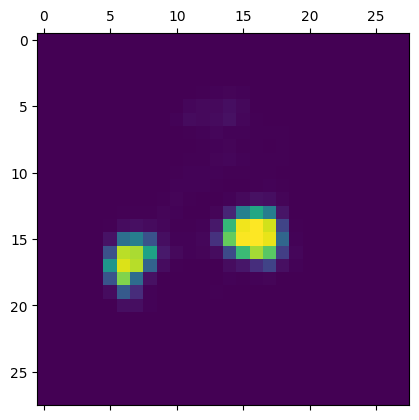

In [12]:
import matplotlib.pyplot as plt
plt.matshow(generate_data_point(cae,28*28,100000).view(28, 28).detach().cpu().numpy())

tensor([ 8.2298e-01, -4.9305e-01, -1.5614e+00, -5.8147e-01,  7.1859e-01,
         5.4540e-01,  1.6393e+00, -9.2839e-01, -3.5858e-01, -2.2980e-01,
        -6.8149e-01,  9.8828e-02, -4.0277e-01, -6.1911e-01, -6.7049e-01,
        -8.4592e-01,  4.0639e-02, -5.2155e-01,  8.4424e-01, -9.2696e-01,
        -6.2905e-01, -2.1705e+00,  9.4603e-01, -1.2149e+00, -5.7891e-02,
        -1.2374e+00,  2.5493e-01,  5.4575e-01, -1.3181e+00,  1.6607e-01,
         7.9996e-01,  1.3128e+00, -2.0067e-01, -6.9207e-01,  9.2238e-01,
        -5.7616e-02, -8.7595e-02, -3.3476e-01,  2.1060e+00,  6.5134e-01,
        -1.9620e-01,  1.1147e+00, -6.1584e-01, -5.0599e-01, -2.6927e-01,
         5.9063e-01, -1.3608e+00, -1.1067e+00,  1.3706e-01, -7.3397e-01,
         1.1006e+00,  9.3594e-01, -3.7264e-01, -1.4044e+00, -1.8754e+00,
        -1.5913e-01,  1.6737e+00,  2.7478e-01,  3.3417e-01, -9.0206e-01,
         1.6307e-01,  1.9485e+00, -1.1782e-01,  7.0868e-01,  5.1570e-01,
        -6.0923e-01,  1.7549e+00,  1.2489e+00,  1.5

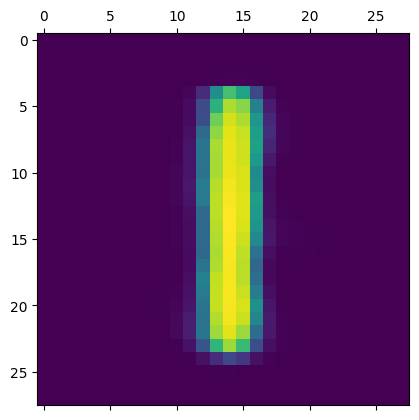

In [35]:
plt.matshow(generate_data_point(dae,28*28,100000).view(28, 28).detach().cpu().numpy())

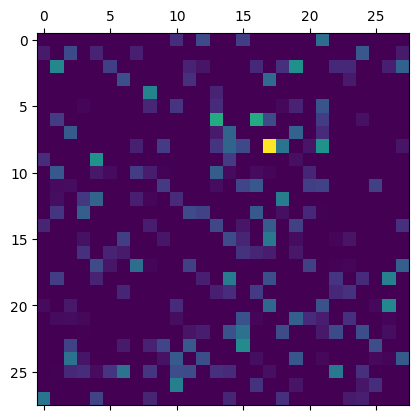

In [ ]:
img,l=dataset[0]
noise=img.to(DEVICE) + torch.randn(img.size()).to(DEVICE)
latent,recon=cae(noise.view(-1,28*28))
plt.matshow(recon.view(28, 28).detach().cpu().numpy())

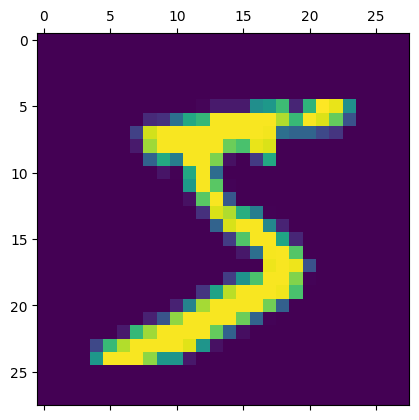

In [ ]:
plt.matshow(img.view(28,28).detach().cpu().numpy())